Prototype crowding metric
First, import the necessary modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db

Now identify the OpSim database, open the connection, and set up the output

In [2]:
database = '/Users/olsen/Documents/LSST/CadenceWorkshop/Aug2015/metrics/enigma_1189_sqlite.db'
opsdb = db.OpsimDatabase(database)
outDir = 'MapExample'
resultsDb = db.ResultsDb(outDir=outDir)

Now we define the metric.  Our definition of crowding is the depth at which fluctuations in the luminosity of the background equal (by fractional contribution) the level of error set by the user.  The metric reads in model r-band luminosity functions from each OpSim field to compute the fluctuations.  Other bands will be added later; for now, the calculation is only relevant for r-band.  If the fluctuations are always below the user-specified level, it returns the maximum magnitude defined in the luminosity function, which is r=35.

In [3]:
# Import BaseMetric, or have it available to inherit from
from lsst.sims.maf.metrics import BaseMetric

# Define our class, inheriting from BaseMetric
class CrowdingMetric(BaseMetric):
    """
    Calculate whether the coadded depth in r has exceeded the confusion limit (other filters to be added later)
    """
    def __init__(self, crowding_error=0.1, lumArea=10., finSeeingCol='finSeeing',  fiveSigCol='fiveSigmaDepth',
                 maps=['lumFuncMap'], **kwargs):
        # Set the values we want to keep for our class.
        cols=[finSeeingCol,fiveSigCol]
        self.crowding_error = crowding_error
        self.seeingCol = finSeeingCol
        self.fiveSigCol = fiveSigCol
        self.lumArea = lumArea
        # Now we have to call the BaseMetric's __init__ method, to get the "framework" part set up.
        # We currently do this using 'super', which just calls BaseMetric's method.
        # The call to super just basically looks like this .. you must pass the columns you need, and the kwargs.
        super(CrowdingMetric, self).__init__(col=cols, **kwargs)#maps=maps, **kwargs)
        
    # Now write out "run" method, the part that does the metric calculation.
    def run(self, dataSlice, slicePoint=None):
        ra1 = slicePoint['ra'] # coordinates from the MAF loop
        dec1 = slicePoint['dec']
 
        #Read in fieldID,RA,DEC
        t=np.genfromtxt('fields.csv', dtype=(int,float,float), delimiter=',', names=True)
        fieldRad = np.sqrt((t['ra']-ra1)**2+(t['dec']-dec1)**2) # approximation

        #Identify closest fieldID
        useField = np.where(fieldRad==min(fieldRad))
        fieldID=t['fieldID'][useField].astype(str)
        #Load LF of fieldID
        lumFuncFile='lfs/field'+fieldID[0]+'lf.txt'
        lumFuncData=np.loadtxt(lumFuncFile)
        magVector=lumFuncData[:,0]
        lumFunc=lumFuncData[:,1]
        
        #Crowding errors calculated for the best seeing image at each slice point
        bestSeeing = min(dataSlice[self.seeingCol])

        lumVector = 10**(-0.4*magVector)
        lumAreaArcsec = self.lumArea*3600.0**2
        
        #Compute crowding error as function of magnitude
        coeff=np.sqrt(np.pi/lumAreaArcsec)*bestSeeing/2.
        crowdError = np.zeros(len(lumFunc))
        i=0
        for mag in magVector:
            lum=10**(-0.4*mag)
            els = np.where(magVector >= mag)
            crowdError[i] = coeff * np.sqrt(np.sum(lumVector[els]**2*lumFunc[els]))/lum
            i+=1
            
        #Locate at which point crowding error is greater than user-defined limit
        aboveCrowd = np.where(crowdError>=self.crowding_error)[0]
        
        if np.size(aboveCrowd) == 0:
            return max(magVector)
        else:
            crowdMag = magVector[max(aboveCrowd[0]-1,0)]
            return crowdMag
        

Set up an instance of the metric and slicer, and issue the SQL query:

In [4]:
metric = CrowdingMetric()
slicer = slicers.OpsimFieldSlicer()
sql = 'night < 365 and filter = "r"' 
bundle = metricBundles.MetricBundle(metric,slicer,sql)


Run the metric and make the plots:

Querying database with constraint night < 365 and filter = "r"
Found 37613 visits
Running:  [0]
Completed metric generation.

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):



Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with night < 365 and filter = "r" sqlconstraint now.
Plotting complete.


//anaconda/opt/lsst/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
Optimal bin calculation tried to make inf bins, returning 200


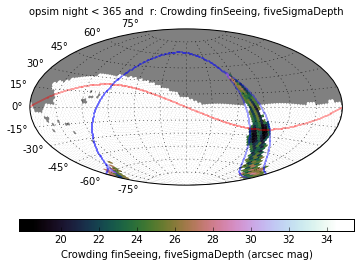

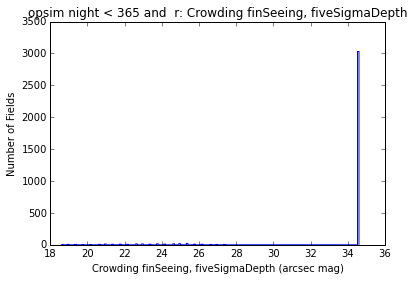

In [5]:
bg = metricBundles.MetricBundleGroup({0:bundle},opsdb, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)